In [13]:
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import pickle

# Paths to model archiecture/weights
existing_project_path = 'C:/Users/Kombangkoe Dias/PycharmProjects/Senior Project/Existing Model/volume'
depth_model_architecture = f'{existing_project_path}/models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = f'{existing_project_path}/models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = f'{existing_project_path}/models/segmentation/mask_rcnn_food_segmentation.h5'

root_path = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103'
root_path_image = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103/FoodSeg103/Images'
root_path_type = 'C:/Users/Kombangkoe Dias/Downloads/FoodSeg103/FoodSeg103/types'

In [3]:
class ExistingEstimator:
    def __init__(self):
        self.estimator = self.getExistingEstimator()

    def getExistingEstimator(self):
        # Create estimator object and intialize
        estimator = VolumeEstimator(arg_init=False)
        with open(depth_model_architecture, 'r') as read_file:
            custom_losses = Losses()
            objs = {'ProjectionLayer': ProjectionLayer,
                    'ReflectionPadding2D': ReflectionPadding2D,
                    'InverseDepthNormalization': InverseDepthNormalization,
                    'AugmentationLayer': AugmentationLayer,
                    'compute_source_loss': custom_losses.compute_source_loss}
            model_architecture_json = json.load(read_file)
            estimator.monovideo = model_from_json(
                model_architecture_json, custom_objects=objs)
        estimator._VolumeEstimator__set_weights_trainable(
            estimator.monovideo, False)
        estimator.monovideo.load_weights(depth_model_weights)
        estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[
            1:]
        depth_net = estimator.monovideo.get_layer('depth_net')
        estimator.depth_model = Model(
            inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
        print('[*] Loaded depth estimation model.')

        # Depth model configuration
        MIN_DEPTH = 0.01
        MAX_DEPTH = 10
        estimator.min_disp = 1 / MAX_DEPTH
        estimator.max_disp = 1 / MIN_DEPTH
        estimator.gt_depth_scale = 0.35  # Ground truth expected median depth

        # Create segmentator object
        estimator.segmentator = FoodSegmentator(segmentation_model_weights)

        # Set plate adjustment relaxation parameter
        estimator.relax_param = 0.01

        return estimator

    def predictMask(self, img_path):
        class predictedMask:
            def __init__(self, masks):
                self.masks = masks

            def __len__(self):
                return masks.shape[-1]

            def __getitem__(self, idx):
                return self.masks[:, :, idx]
        masks = self.estimator.segmentator.infer_masks(img_path)
        return predictedMask(masks)


In [4]:
class Utils:
    def __init__(self):
        self.ingredients, self.ingredients_no_type = self.getIngredients()
        self.colors = self.getColors()
        self.palettes = self.getPalettes()
    def getIngredients(self):
        names = ['carbohydrates', 'protein', 'vegetables', 'fruits', 'desserts', 'snacks', 'additives', 'drinks', 'others']
        ingredients = dict()
        ingredients_no_type = dict()
        for name in names:
            ingredients[name] = {}
            with open(f"{root_path_type}/{name}.txt") as f:
                for line in f:
                    data = line.strip().split()
                    Id = data[0]
                    food_type = ' '.join(data[1:])
                    ingredients[name][int(Id)] = food_type
                    ingredients_no_type[int(Id)] = {"food_type": food_type}
        return ingredients, ingredients_no_type
    def findType(self, label):
        for ingredient in self.ingredients.keys():
            if label in self.ingredients[ingredient].keys():
                return ingredient
        return False
    def combineMask(self, imageData, masks, Ids):
        labels = imageData['labels']
        img = Image.open(imageData['img'])
        start = np.zeros((img.size[1], img.size[0])).astype('uint8')
        for idx, mask in enumerate(masks):
            start[mask == 1] = labels[Ids[idx]]
        start = start.astype('uint8')
        combined_mask = Image.fromarray(start, mode='L')
        return combined_mask
    def getColors(self):
        colors = dict()
        with open(f'{root_path}/FoodSeg103/colors.txt') as f:
            for line in f:
                line = line.strip().split()
                color = (int(line[1]), int(line[2]), int(line[3]))
                self.ingredients[line[0]]['color'] = color
                colors[line[0]] = color
        return colors
    def getPalettes(self):
        palettes = []
        for i in range(104):
            ingredient_type = self.findType(i)
            color = self.colors[ingredient_type]
            for rgb in color:
                palettes.append(rgb)
        return palettes
    def plotMask(self,imageData, masks=None, Ids=None):            
        image = imageData['img']
        image = Image.open(image)
        image = image.convert('RGBA')
        if masks is not None:
            mask = self.combineMask(imageData, masks, Ids)
        else:
            mask = imageData['mask_dir']
            mask = np.array(Image.open(mask))
            mask = Image.fromarray(mask, mode='L')
        mask.putpalette(self.palettes)
        mask = mask.convert('RGBA')
        image_with_mask = Image.blend(image, mask, 0.65)
        return image, mask, image_with_mask

In [5]:
class FoodSeg103SegmentationMask():
    def __init__(self, root, train=True, transforms=None):
        if train:
            path = 'train'
        else:
            path = 'test'
        self.root = root
        self.transforms = transforms
        self.imgs = list(
            sorted(os.listdir(os.path.join(root, f'img_dir/{path}'))))
        self.masks = list(
            sorted(os.listdir(os.path.join(root, f'ann_dir/{path}'))))
        self.train = train
        filtered = [1078, 3642, 4909]
        if train:
            for idx in filtered:
                self.imgs.pop(idx)
                self.masks.pop(idx)
        self.pickle = False

    def getFromPickle(self, option):
        self.pickle = option

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.root, 'img_dir/train' if self.train else 'img_dir/test', self.imgs[idx])
        mask_path = os.path.join(
            self.root, 'ann_dir/train' if self.train else 'ann_dir/test', self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        Ids = np.unique(mask)
        Ids = Ids[1:]
        masks = []
        for id in Ids:
            masks.append(mask == id)
        num_mask = len(Ids)
        boxes = []
        for i in range(num_mask):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = np.array(boxes)
        labels = np.array(Ids)
        masks = np.array(masks, dtype=int)
        # image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # iscrowd = torch.zeros((num_mask,), dtype=torch.int64)
        data = {}
        data['img'] = img_path
        data['masks'] = masks
        data['mask_dir'] = mask_path
        data['labels'] = labels
        data['boxes'] = boxes
        for a in area:
            if a == 0:
                return self.__getitem__(idx-1)
        return data

    def __len__(self):
        return len(self.imgs)


In [9]:
estimator = ExistingEstimator()

[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights C:/Users/Kombangkoe Dias/PycharmProjects/Senior Project/Existing Model/volume/models/segmentation/mask_rcnn_food_segmentation.h5


In [10]:
dataset = FoodSeg103SegmentationMask(root_path_image, train=False)

In [158]:
class Visualization:
    def __init__(self, agent):
        self.agent = agent
    def realMasksVSpredictedMasks(self, data):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,30))
        real_mask_visual = self.agent.utils.plotMask(data)
        real = real_mask_visual[2]
        real_only_mask = real_mask_visual[1]
        real_masks = data['masks']
        masks = agent.estimator.predictMask(data['img'])
        _ , Ids, _ = agent.calculateIOU(masks, real_masks)
        predicted_mask_visual = agent.utils.plotMask(data, masks, Ids)
        predicted = predicted_mask_visual[2]
        predicted_only_mask = predicted_mask_visual[1]
        imgs = [[real, predicted], [real_only_mask, predicted_only_mask]]
        axes[0,0].set_title('real', color='white', fontsize=50)
        axes[0,1].set_title('predicted', color='white', fontsize=50)
        axes[1,0].set_title('real_mask', color='white', fontsize=50)
        axes[1,1].set_title('predicted_mask', color='white',fontsize=50)
        for i in range(2):
            for j in range(2):
                axes[i, j].imshow(imgs[i][j])
    def histogramOfOverallIOUs(self):
        x = [IOU for IOU, area in self.agent.overallIOUs]
        num_bins = 10
        n, bins, patches = plt.hist(x, num_bins, facecolor='green', edgecolor='black', linewidth=1)
        ax = plt.gca()
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        plt.xlabel('IOU', color='white')
        plt.ylabel('frequency', color='white')
        plt.title('Histogram of overall IOU', color='white')
        plt.show()
        

In [159]:
class SegmentationBaseline():
    def __init__(self, estimator=None, dataset=None, IOUs=dict(), overallIOUs=list(), baseline=None):
        if estimator is not None:
            self.estimator = estimator
        else:
            self.estimator = ExistingEstimator()
        if dataset is not None:
            self.dataset = dataset
        else:
            self.dataset = FoodSeg103SegmentationMask(root_path_image, train=False)
        self.utils = Utils()
        self.IOUs = IOUs
        if len(IOUs) == 0:
            for i in range(104):
                self.IOUs[i] = list()
        self.overallIOUs = overallIOUs
        self.baseline = baseline
        directories = os.listdir('.')
        if 'IOUs.pickle' in directories:
            with open('IOUs.pickle', 'rb') as f:
                self.IOUs = pickle.load(f) 
        if 'overallIOUs.pickle' in directories:
            with open('overallIOUs.pickle', 'rb') as f:
                self.overallIOUs = pickle.load(f)
        if 'baseline.pickle' in directories:
            with open('baseline.pickle', 'rb') as f:
                self.baseline = pickle.load(f)
        self.visualization = Visualization(self)
    def findSegmentationIndex(self, predicted_mask, real_masks):
        predicted_idx = 0
        highest_pixels_intersection = 0
        for idx, real_mask in enumerate(real_masks):
            pixels_intersection = self.comparePartialMask(predicted_mask, real_mask)
            if pixels_intersection > highest_pixels_intersection:
                highest_pixels_intersection = pixels_intersection
                predicted_idx = idx
        return predicted_idx, highest_pixels_intersection

    def comparePartialMask(self, predicted_mask, real_mask):
        predicted_mask = np.array(predicted_mask)
        real_mask = np.array(real_mask)
        if predicted_mask.shape != real_mask.shape:
            if predicted_mask.T.shape == real_mask.shape:
                predicted_mask = predicted_mask.T
            else:
                print("The shape of the masks are not the same")
                return
        compared_result = predicted_mask * real_mask
        pixels_intersection = len(np.where(compared_result == 1)[0])
        return pixels_intersection

    def calculateIOU(self, predicted_masks, real_masks):
        real_masks_copy = []
        predicted_idxs = []
        for real_mask in real_masks:
            real_masks_copy.append(real_mask.copy())
        for predicted_mask in predicted_masks:
            predicted_idx, _ = self.findSegmentationIndex(
                predicted_mask, real_masks)
            predicted_idxs.append(predicted_idx)
            real_masks[predicted_idx] = real_masks[predicted_idx].astype('int64')
            real_idx_mask = real_masks[predicted_idx]
            real_idx_mask -= predicted_mask.astype('int64')  # erase the intersected 1s
            #  real- predict= new_real
            #   0   -  0    =   0     => correctly predict the 0
            #   1   -  0    =   1     => not yet covered (might be covered by another predicted mask)
            #   0   -  1    =  -1     => incorrectly predict the 1, marked with negative values
            #   1   -  1    =   0     => correctly predict the 1
            #  <0   -  0    =  <0     => marked negatives stay negative
            #  <0   -  1    =  <0     => marked negatives stay negative
            real_masks_copy[predicted_idx] = real_masks_copy[predicted_idx].astype('int64')
            real_idx_mask_copy = real_masks_copy[predicted_idx]
            real_idx_mask_copy |= predicted_mask.astype('int64')  # Total (Union)
        # say set of mask in real is A and mask in predict is B
        # the number of all 1s and negative values that are left
        # is (A - B) U (B - A) , set this to tmp
        # so we can calculate the Intersection part by Unions - tmp
        tmp = [0] * len(real_masks)
        Intersections = [0] * len(real_masks)
        Unions = [0] * len(real_masks)
        for idx, erased_real_mask in enumerate(real_masks):
            Unions[idx] = np.count_nonzero(real_masks_copy[idx])  # the union
            tmp[idx] += np.count_nonzero(erased_real_mask == 1)  # 1s
            tmp[idx] += np.count_nonzero(erased_real_mask < 0)  # negatives
            Intersections[idx] = Unions[idx] - tmp[idx]
        IOUs = np.array(Intersections) / np.array(Unions)
        return IOUs, predicted_idxs, Unions

    def getMaskedArea(self, img_path, mask):
        img = Image.open(img_path)
        pos = np.where(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        box = (xmin, ymin, xmax, ymax)
        crop_image = self.cropImage(img, box)
        return crop_image

    def cropImage(self, img, box):
        box = tuple(box)
        img = img.crop(box)
        return img

    def findBaseline(self):
        class Baseline:
            def __init__(self,normalClassBaseline, pixelClassBaseline, normalOverallBaseline,
                         pixelOverallBaseline):
                self.normalClassBaseline = normalClassBaseline
                self.pixelClassBaseline = pixelClassBaseline
                self.normalOverallBaseline = normalOverallBaseline
                self.pixelOverallBaseline = pixelOverallBaseline
        for data in tqdm(self.dataset):
            self.calculateAndStoreIOUs(data)
        normalClassBaseline = [] # mIOUs of each class (unweighted)
        pixelClassBaseline = [] # mIOUs weighted by union-area of each class
        normalOverallBaseline = 0 # overall mIOUs (unweighted)
        pixelOverallBaseline = 0 # overall mIOUs weighted by union-area
        for label in range(104):
            normalClassBaseline.append(0)
            pixelClassBaseline.append(0)
            if len(self.IOUs[label]) != 0:
                normalClassBaseline[label] = sum(IOU for IOU,area in self.IOUs[label])/ len(self.IOUs[label])
                pixelClassBaseline[label] = sum(IOU * area for IOU,area in self.IOUs[label]) / sum(area for IOU,area in self.IOUs[label])
        normalOverallBaseline = sum(IOU for IOU,area in self.overallIOUs)/ len(self.overallIOUs)
        pixelOverallBaseline = sum(IOU * area for IOU,area in self.overallIOUs) / sum(area for IOU, area in self.overallIOUs)
        self.baseline = Baseline(normalClassBaseline, pixelClassBaseline, normalOverallBaseline,
                         pixelOverallBaseline)
        self.storePickle()
        return self.baseline
    def calculateAndStoreIOUs(self, data, store=True, returnData=False):
        img = data['img']
        labels = data['labels']
        predicted_masks = self.estimator.predictMask(img)
        real_masks = data['masks']
        combined_real_mask = np.array(Image.open(data['mask_dir']))
        IOUs, predicted_idxs, Unions = self.calculateIOU(predicted_masks, real_masks)
        # real_masks are now erased and cannot be used below this line
        # use combined_real_mask instead
        combined_predicted_mask = np.array(self.utils.combineMask(data, predicted_masks, predicted_idxs))
        for idx, label in enumerate(labels):
            if store:
                self.IOUs[label].append((IOUs[idx], Unions[idx]))
        # calculate the overall IOU
        Union = np.count_nonzero(combined_predicted_mask | combined_real_mask)
        condition1 = combined_predicted_mask != 0
        condition2 = combined_predicted_mask == combined_real_mask
        Intersection = np.count_nonzero(condition1 & condition2)
        overallIOUs = Intersection/Union
        if store:
            self.overallIOUs.append((overallIOUs, Union))
        if returnData:
            return {'img': img, 'predicted_masks': predicted_masks,
                    'combined_predicted_mask': combined_predicted_mask,
                    'combined_real_mask': combined_real_mask,
                    'IOUs': (IOUs, overallIOUs), 'Unions': Unions, 'Union': Union, 
                    'labels': labels}
    def storePickle(self):
        import pickle
        with open('baseline.pickle', 'wb') as f:
            pickle.dump(agent.baseline, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open('IOUs.pickle', 'wb') as f:
            pickle.dump(agent.IOUs, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open('overallIOUs.pickle', 'wb') as f:
            pickle.dump(agent.overallIOUs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [160]:
agent = SegmentationBaseline(estimator, dataset)

In [161]:
# agent.findBaseline() # find the baseline

In [162]:
agent.baseline.normalOverallBaseline # the mean of overall IOUs

0.6205624116716943

In [163]:
agent.baseline.pixelOverallBaseline # the mean of overall IOUs weighted by Union areas

0.6203609105684671

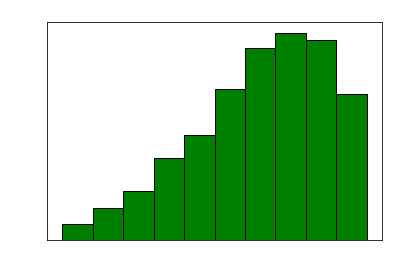

In [164]:
agent.visualization.histogramOfOverallIOUs()

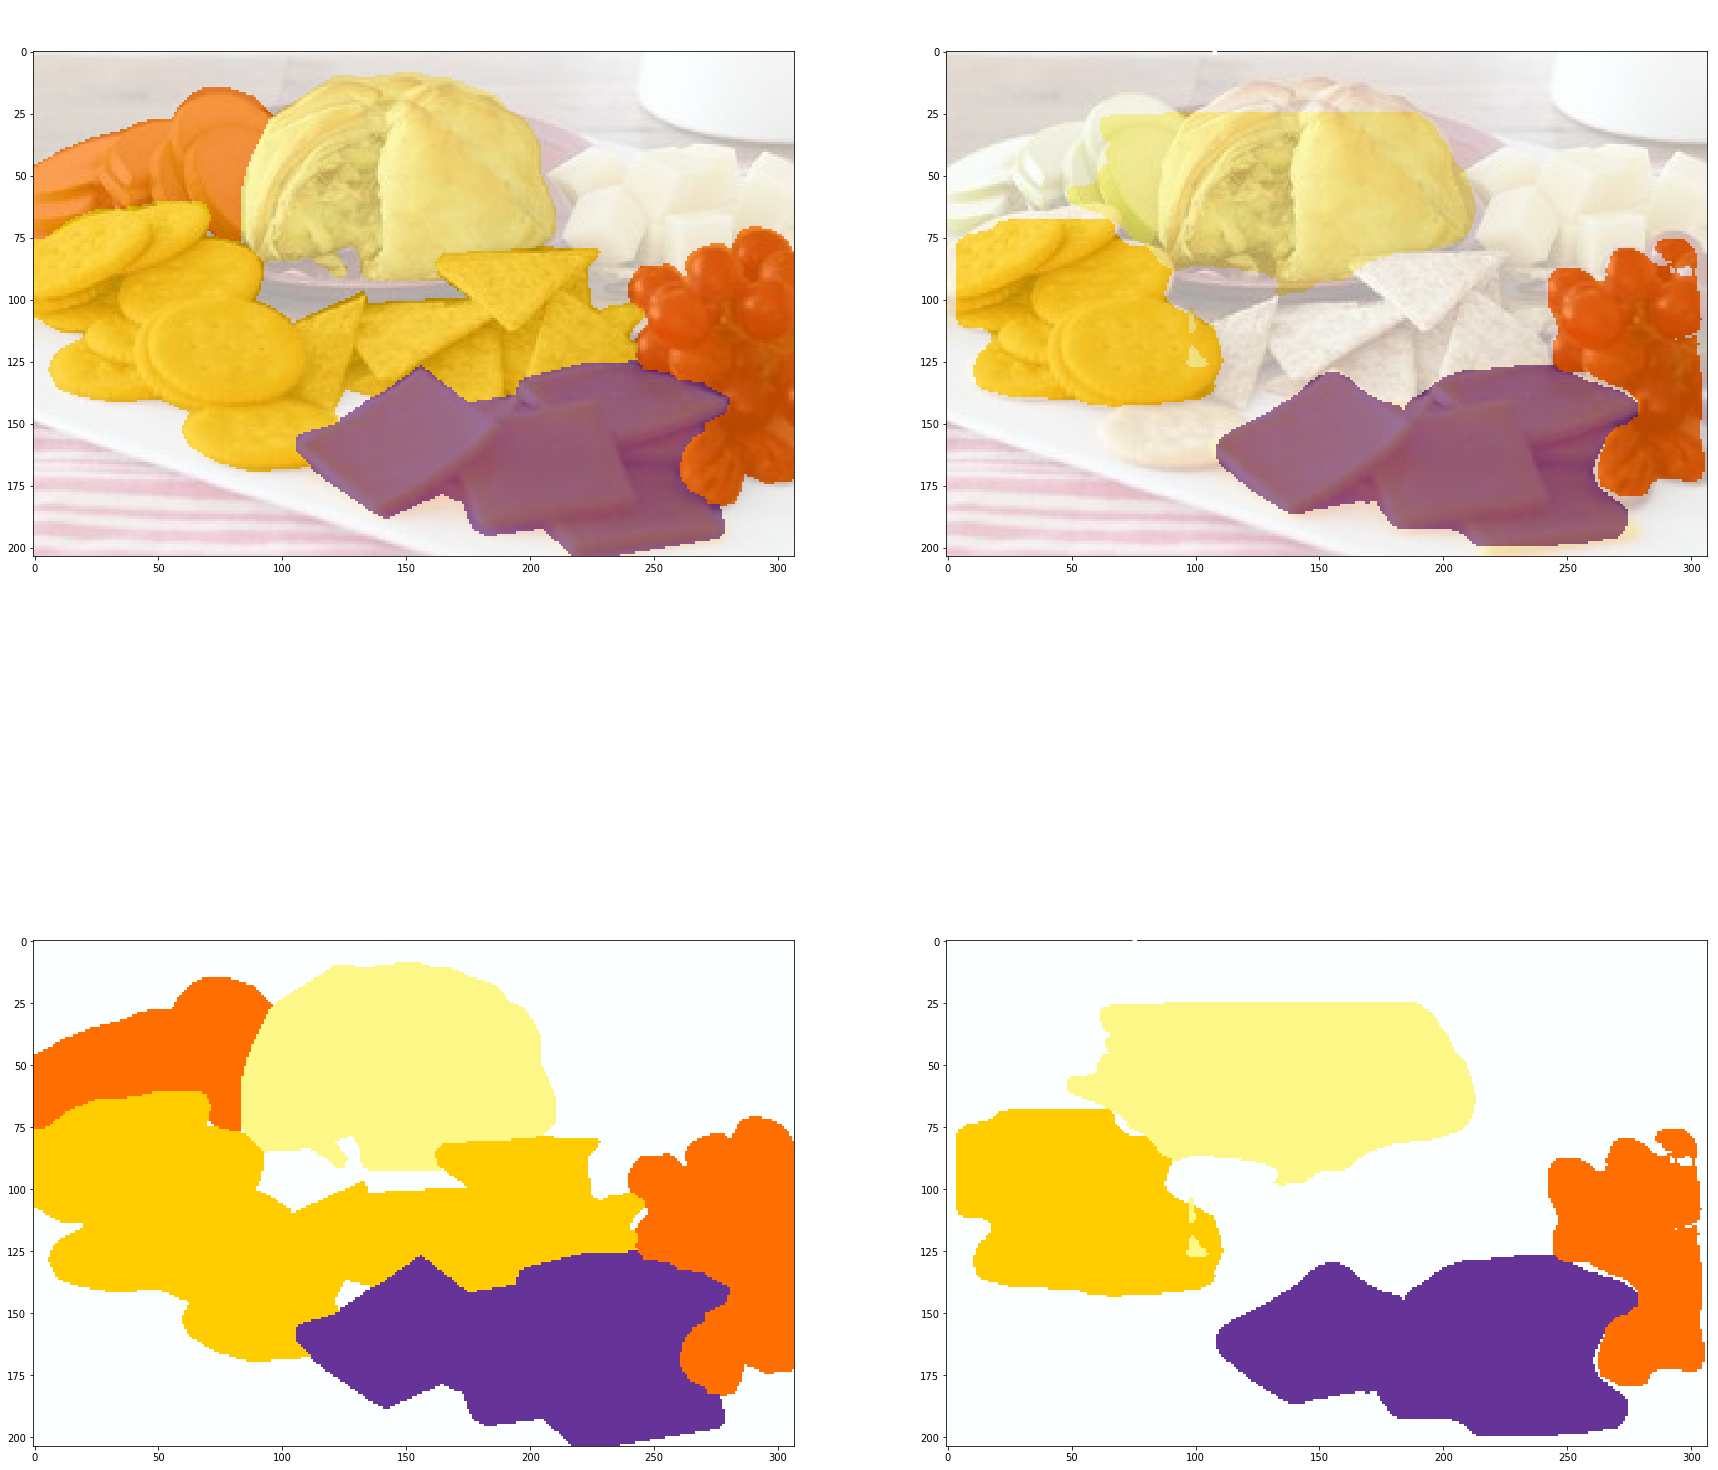

In [146]:
agent.visualization.realMasksVSpredictedMasks(dataset[6])

In [ ]:
for i in range(masks.shape[-1]):
    mask = masks[:, :, i]
    print(mask.shape)


In [16]:
losses = []

In [17]:
def calculateLabelsLoss(estimator, dataset: FoodSeg103SegmentationMask):
    mean_absolute_loss = 0
    for data in tqdm(dataset):
        img = data['img']
        prediction = estimator.predictMask(img)
        num_predicted_labels = len(prediction)ME
        num_real_labels = len(data['labels'])
        loss = abs(num_predicted_labels - num_real_labels)
        mean_absolute_loss += loss
        losses.append(loss)
    mean_absolute_loss /= len(dataset)
    return mean_absolute_loss


In [18]:
label_mse = calculateLabelsLoss(estimator=estimator, dataset=dataset)
label_mse


100%|██████████| 4980/4980 [15:35:36<00:00, 11.27s/it]


2.458232931726908

In [19]:
unique, counts = np.unique(losses, return_counts=True)
frequencies = np.array((unique, counts)).T


In [20]:
frequencies


array([[   0,  815],
       [   1, 1362],
       [   2,  963],
       [   3,  632],
       [   4,  426],
       [   5,  256],
       [   6,  194],
       [   7,  117],
       [   8,   78],
       [   9,   49],
       [  10,   33],
       [  11,   24],
       [  12,   10],
       [  13,    5],
       [  14,    5],
       [  15,    5],
       [  16,    2],
       [  17,    2],
       [  18,    2]], dtype=int64)

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 6 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3047805876724975, 0.06520950197838898, -0.4756188910031168, -0.8772310934826101]
[*] Estimated volume: 1.6913019963819438 L


<IPython.core.display.Javascript object>


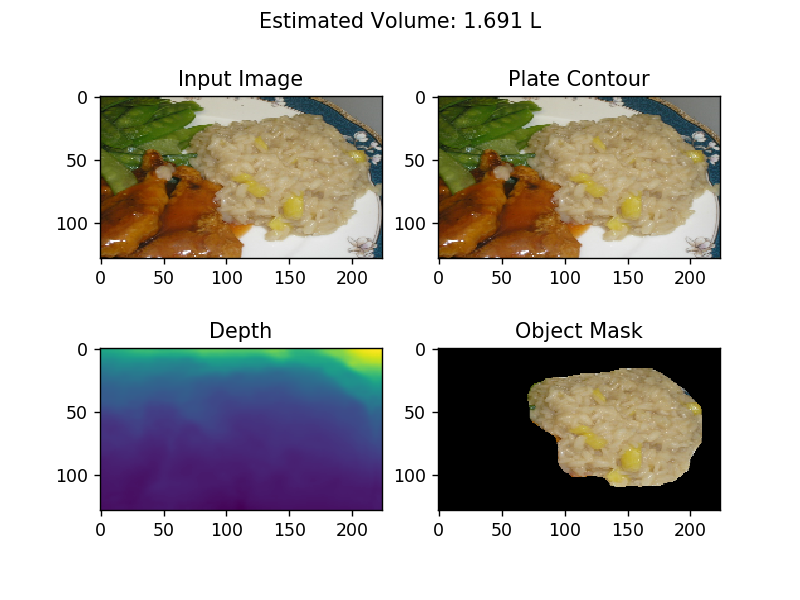

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3142553517068179, 0.01458855700648336, -0.4145607746217528, -0.9099046862993293]
[*] Estimated volume: 0.0848700502851178 L


<IPython.core.display.Javascript object>


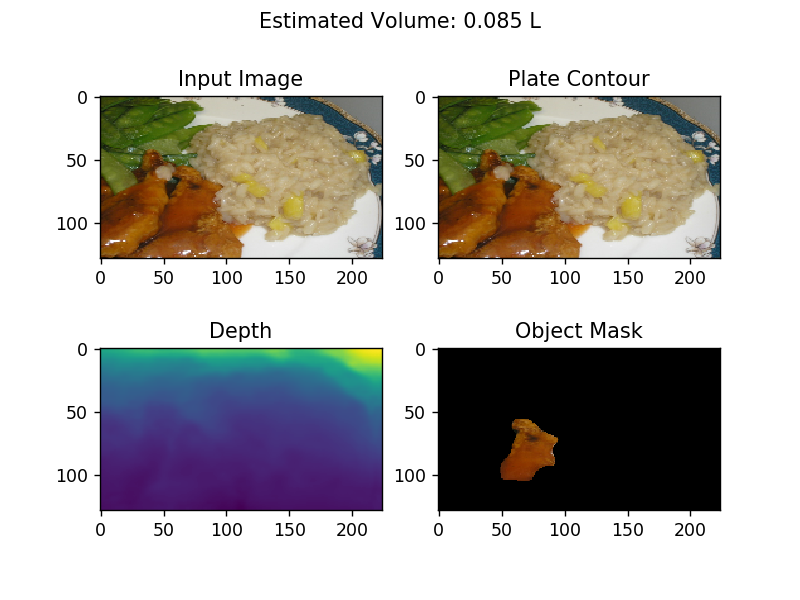

[*] Estimated plane parameters (w0,w1,w2,w3): [0.30246787513734597, -0.0679161663727076, -0.37034364323566177, -0.9264086464731272]
[*] Estimated volume: 0.18878484146467744 L


<IPython.core.display.Javascript object>


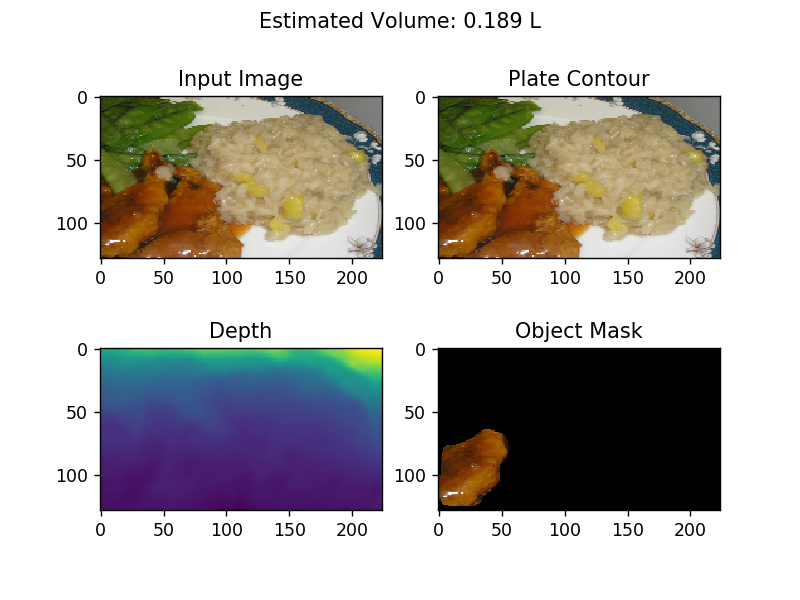

[*] Estimated plane parameters (w0,w1,w2,w3): [0.2685949138092626, -0.27639593970454757, -0.3550142524612801, -0.8930678390045174]
[*] Estimated volume: 0.025591041456386503 L


<IPython.core.display.Javascript object>


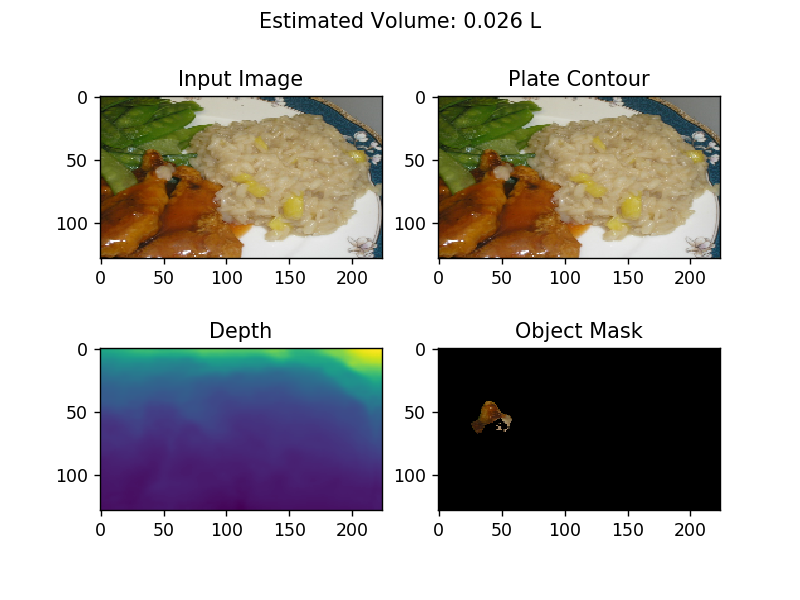

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3050200114216025, -0.1725854353078211, -0.33366444184830046, -0.926759034358809]
[*] Estimated volume: 0.05573604430194905 L


<IPython.core.display.Javascript object>


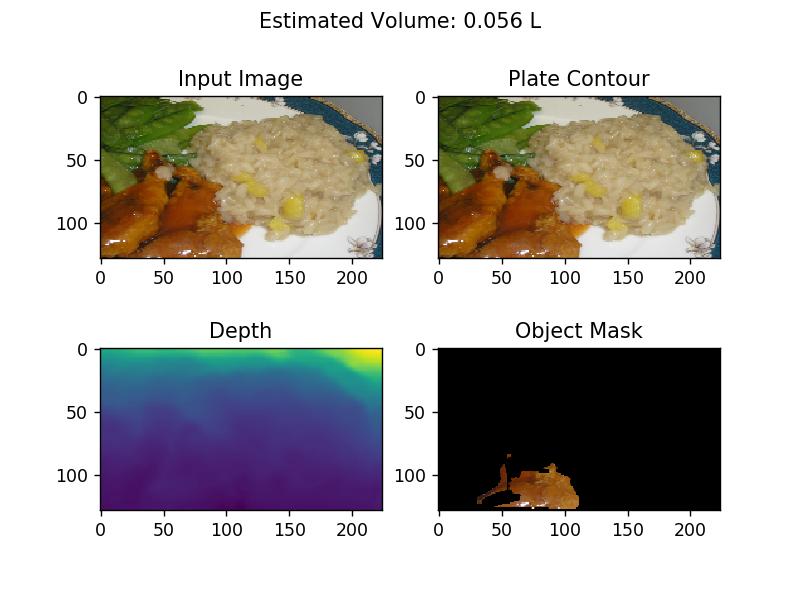

[*] Estimated plane parameters (w0,w1,w2,w3): [0.2346603194553012, -0.034697957384354494, -0.6583460438566602, -0.7519152467476888]
[*] Estimated volume: 0.4327261400130335 L


<IPython.core.display.Javascript object>


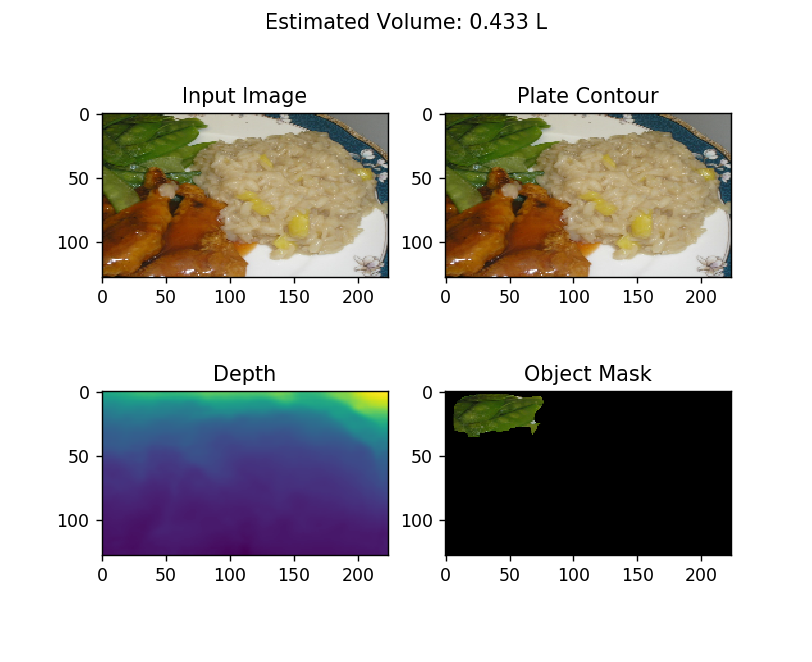

E:\Anaconda\envs\volume\lib\site-packages\pythreejs\traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.07243643790800855, 0.0951671806733381, 0.…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.06393274111236084, 0.2683004836715266, 0.0…

<IPython.core.display.Javascript object>


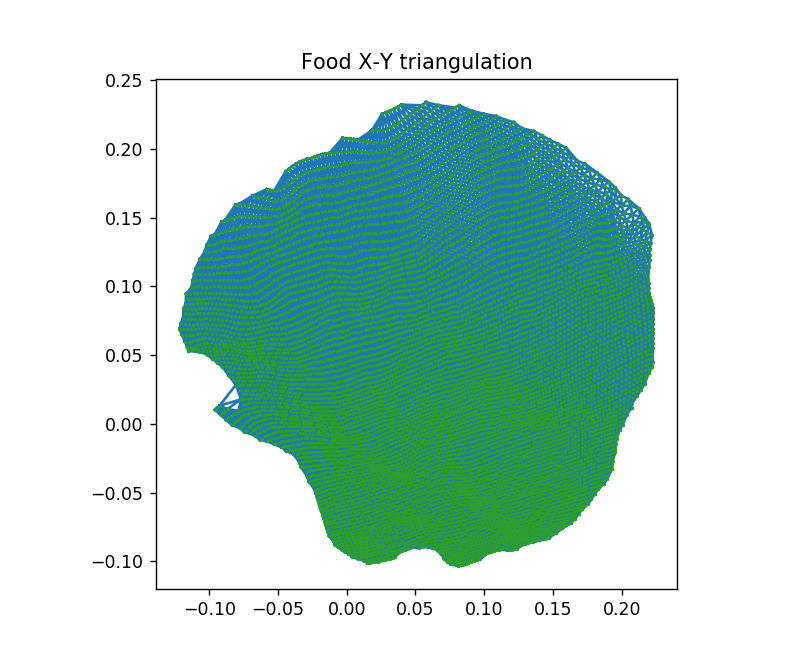

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.08253810539336527, 0.14618414080512349, 0.…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.07779376435920489, -0.04914240346532694, …

<IPython.core.display.Javascript object>


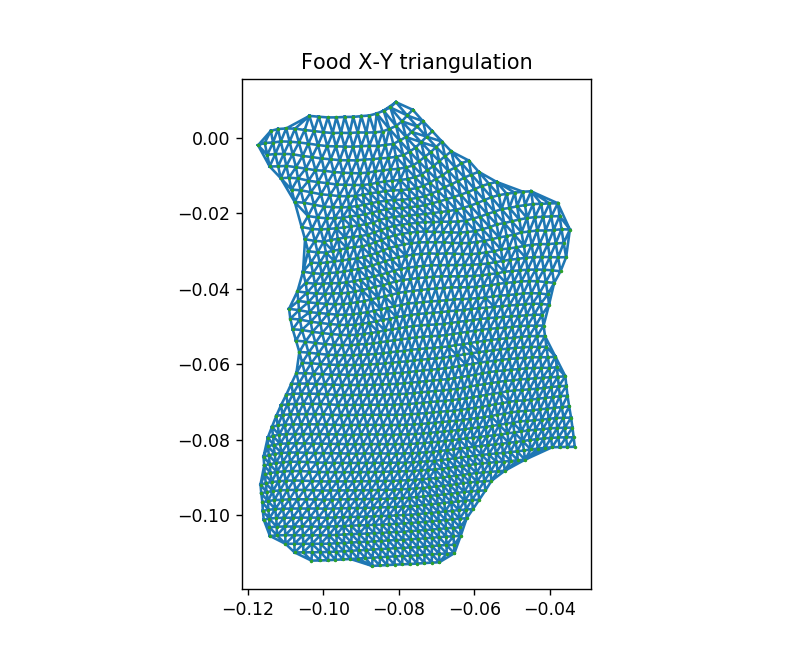

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.1644341274976587, 0.21867463986958502, 0.1…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.18220254836228292, 0.03803007824427563, 0…

<IPython.core.display.Javascript object>


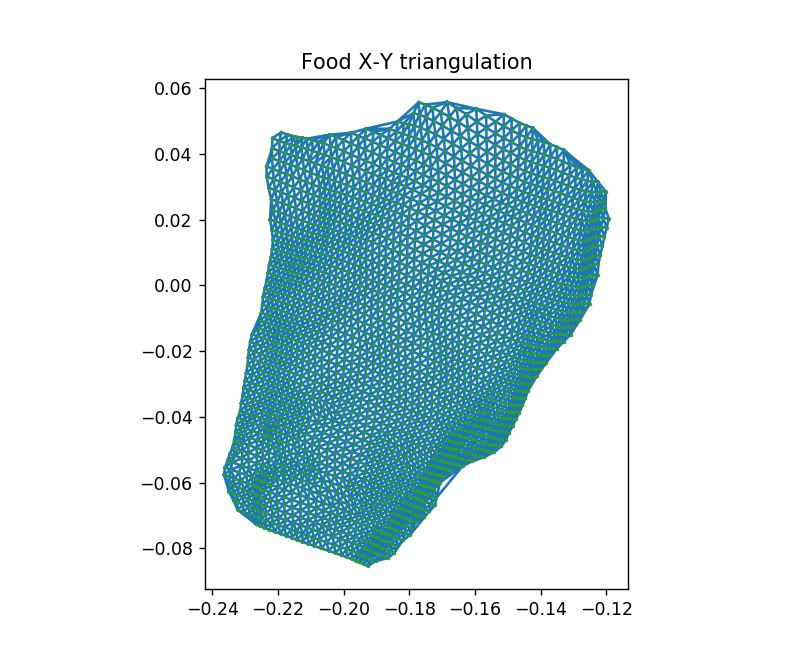

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.1602091644403418, -0.019732223823666573, 0…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.002778580137801007, 0.38420572101733796, …

<IPython.core.display.Javascript object>


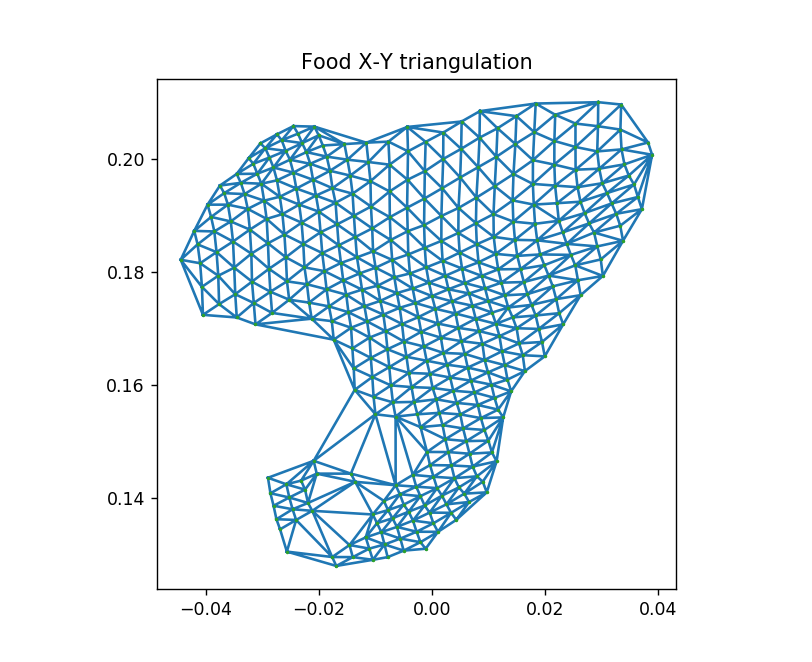

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.06347741782956115, 0.2656308037198949, 0.1…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.1314470585125831, 0.028085733776936694, 0…

<IPython.core.display.Javascript object>


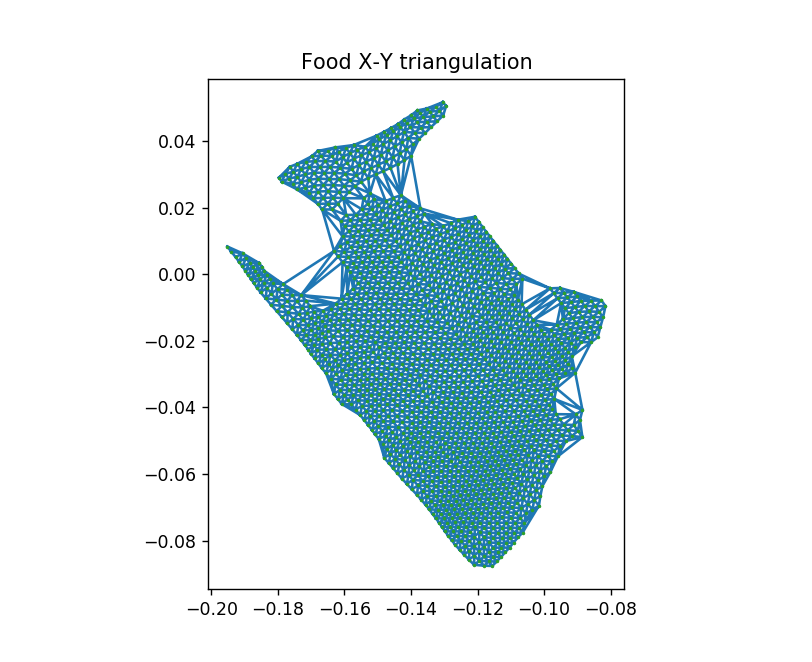

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.22534882629350309, -0.09299925381457932, 0…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.19708483728572154, 0.7080986491163777, 0.…

<IPython.core.display.Javascript object>


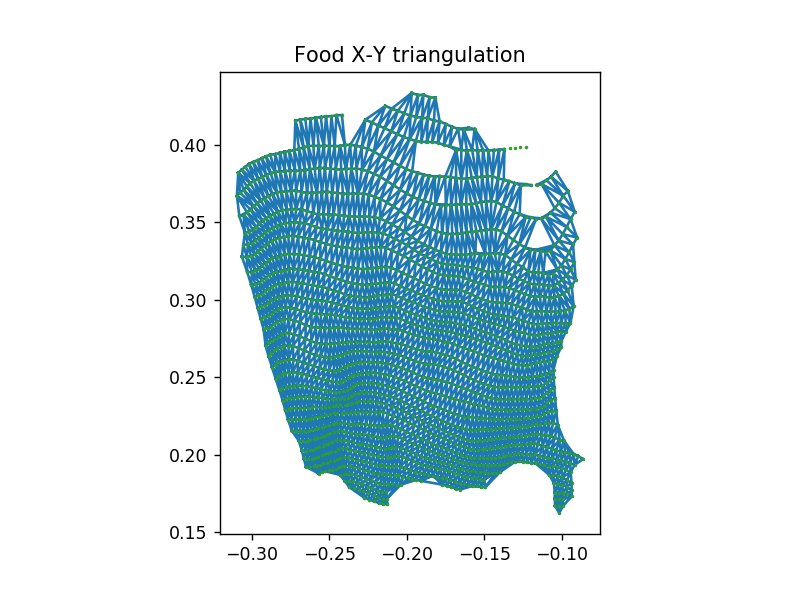

In [105]:
%matplotlib notebook

# Estimate volumes in input image
input_image = dataset[0]['img']
plate_diameter = 0.35  # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter,
                                                   plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df,
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)

    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:, 0] *= -1
    object_points_df.values[:, 2] *= -1
    non_object_points_df.values[:, 0] *= -1
    non_object_points_df.values[:, 2] *= -1
    plane_points_df.values[:, 0] *= -1
    plane_points_df.values[:, 2] *= -1

    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001,
                  use_as_color='z', cmap='cool', scene=scene)

    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(
        initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005,
                              use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:, 2] > 0]
    plt.figure()
    plt.triplot(volume_points[:, 0], volume_points[:, 1], simplices)
    plt.plot(volume_points[:, 0], volume_points[:, 1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()
